# Статистический анализ сервиса аренды самокатов

исходные датасеты содержат инфрмацию о пользователях сервиса аренды самокатов. в ходе исследования мы проанализируем данные и проверим несколько гипотез:
* `Гипотеза №1`. Пользователи с подпиской тратят больше времени на поездки
* `Гипотеза №2`. Среднее расстояние, которое проезжает пользователь с подпиской, не превышает оптимальую дистанцию поездки
* `Гипотеза №3`. Помесячная выручка от пользователей с подпиской больше, чем от обычных пользователей.

условия пользования сервисом:
* без подписки:
  * абонентская плата отсутствует;
  * стоимость одной минуты поездки — 8 рублей;
  * стоимость старта (начала поездки) — 50 рублей;  
  
* с подпиской Ultra:
    * абонентская плата — 199 рублей в месяц;
    * стоимость одной минуты поездки — 6 рублей;
    * стоимость старта — бесплатно.

## Описание данных

**датасет №1. Пользователи**:
* `user_id` &mdash; уникальный идентификатор пользователя
* `name` &mdash; имя пользователя
* `age` &mdash; возраст пользователя
* `city` &mdash; город
* `subscription_type` &mdash; тип подписки (free или ultra)

**датасет №2. Поездки**:
* `user_id` &mdash; уникальный идентификатор пользователя
* `distance` &mdash; дистанция одной поездки, в метрах
* `duration` &mdash; продолжительность одной поездки, в минутах
* `date` &mdash; дата поездки

**датасет №3. Тарифы**:
* `subscription_type` &mdash; тип подписки
* `minute_price` &mdash; стоимость одной минуты поездки
* `start_ride_price` &mdash; стоимость начала поездки
* `ubscription_fee` &mdash; стоимость ежемесячного платежа


## План
1. Ознакомление с данными
2. Предобработка данных
3. Исследовательский анализ данных  
    3.1. CITY  
    3.2. SUBSCRIPTION TYPE  
    3.3. AGE  
    3.4. DISTANCE  
    3.5. DURATION  
4. Объединение данных и сравнение показателей  
    4.1. Создание датасетов, необходимых для статистического анализа данных  
    4.2. Сравнение распределений данных  
5. Подсчёт выручки
6. Проверка гипотез  
    6.1. Гипотеза 1. Продолжительность  
    6.2. Гипотеза 2. Дистанция  
    6.3. Гипотеза 3. Выручка  
    6.4. Обращения в техподдержку  
7. Рассчёт маркетинговых активностей  
    7.1. Промокоды на подписку  
    7.2. Рассылка push-уведомлений  
8. Выводы

## 1. Ознакомление с данными.

запишем датасеты в переменные с соответствующими названиями:
* `users` &mdash; тут будут храниться данные о пользователях сервиса
* `rides` &mdash; тут будут храниться данные о поездках, которые они совершили
* `subscriptions` &mdash; а тут информация о тарифах 

In [1]:
# импортируем необходимые для работы библиотеки.
import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(rc={'figure.figsize':(11.7,8.27)}, style='white')

In [2]:
# импортируем данные:
try:
    users = pd.read_csv('D:\docs\DS\\users_go.csv')
except:
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')

try:
    rides = pd.read_csv('D:\docs\DS\\rides_go.csv')
except:
    rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
    
try:
    subscriptions = pd.read_csv('D:\docs\DS\\subscriptions_go.csv')
except:
    subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

теперь посмотрим на каждый датасет. начнём с пользователей:

In [3]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


нет пропусков, столбцы названы корректно, корректно задан тип данных. на первый взгляд всё выглядит отлично. ознакомимся с информацией о поездках:

In [4]:
rides.info()
rides.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


здесь также без пропусков. количество строк в поездках в 11 раз превышает количество строк в пользователях, что ожидаемо: на одного клиента может приходиться несколько поездок. информация о дате имеет некорректный тип. исправим это, прежде чем переходить к следующему датасету: 

In [5]:
rides['date'] = pd.to_datetime(rides['date'])
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [6]:
subscriptions.info()
subscriptions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


как и было заявлено, у сервиса только два тарифа: с подпиской и без. стоимость поездок соответствует фактической информации. можно приступать к предобработке данных.

#### Промежуточный итог
в процессе ознакомления с датасетами мы убедлились в корректности оформления данных и в отсутствии промущенных значений, а также задали корректный тип данных для информации о дате поездки. все три датасета готовы к предобработке данных.

## 2. Предобработка данных

в датасете, содержащем информацию о поездках, создадим новый столбец `month`, в который внесём информацию о месяце поездки, что пригодится нам в дальнейшем при расчёте помесячной выручки от каждого клиента. предварительно оценим, данные за какой период времени содержит датасет (если данные о поездках более, чем два года, нужно будет учесть это при подсчёте выручки за месяц): 

In [7]:
rides['date'].dt.year.unique()

array([2021])

датасет содержит данные о поездках только за 2021 год &mdash; можно смело отделять месяц в самостоятельную колонку:

In [8]:
rides['month'] = pd.DatetimeIndex(rides['date']).month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


в столбце `distance` округлим значения до двух знаков после запятой:

In [9]:
rides['distance'] = rides['distance'].round(2)
rides

,user_id,distance,duration,date,month
0,1,4409.92,25.599769,2021-01-01,1
1,1,2617.59,15.816871,2021-01-18,1
2,1,754.16,6.232113,2021-04-20,4
3,1,2694.78,18.511000,2021-08-11,8
4,1,4028.69,26.265803,2021-08-28,8
...,...,...,...,...,...
18063,1534,3781.10,19.822962,2021-11-04,11
18064,1534,2840.42,21.409799,2021-11-16,11
18065,1534,3826.19,18.435051,2021-11-18,11
18066,1534,2902.31,16.674362,2021-11-27,11


далее в исследовании для подсчёта выручки нам потребуется округлённое значение длительности поездки. согласно рекомендациям, используем округление до целого в большую сторону, так же изменим тип данных столбца на `int`

In [10]:
rides['duration'] = np.ceil(rides['duration']).astype('int')
rides

,user_id,distance,duration,date,month
0,1,4409.92,26,2021-01-01,1
1,1,2617.59,16,2021-01-18,1
2,1,754.16,7,2021-04-20,4
3,1,2694.78,19,2021-08-11,8
4,1,4028.69,27,2021-08-28,8
...,...,...,...,...,...
18063,1534,3781.10,20,2021-11-04,11
18064,1534,2840.42,22,2021-11-16,11
18065,1534,3826.19,19,2021-11-18,11
18066,1534,2902.31,17,2021-11-27,11


на этапе знакомства с данными мы определили, что в датасетах нет пропусков, теперь проверим `rides` и `users` на наличие дубликатов:

In [11]:
print(f"Количество дубликатов в данных о поездках: {rides.duplicated().sum()} \n"
      f"Количество дубликатов в данных о пользователях: {users.duplicated().sum()}"
     )

Количество дубликатов в данных о поездках: 0 
Количество дубликатов в данных о пользователях: 31


31 пользователя случайно вписали дважды. уберём полностью дублирующиеся строки из датасета: поставленные перед нами задачи исключают возможность задвоения данных о пользователях.

In [12]:
users = users.drop_duplicates().reset_index(drop=True)
users.duplicated().sum()

0

#### Промежуточный итог
на этапе предобработки данных мы создали новый столбец `month`, округлили данные в столбцах `distance` и `duration`, а также выявили и устранили 11 дублирующихся записей о пользоватлях. датасеты готовы к исследовательскому анализу.
## 3. Исследовательский анализ данных

перед тем как приступить к анализу данных, напишем функции, которыми в дальнейшем будем пользоваться при построении графиков.

In [13]:
# функция для построения ящика с усами
def data_boxplot (df, column, title):    
    plt.title(title)
    df.boxplot(column=[column])
    q1 = df[column].quantile(0.25).round(1)
    q3 = df[column].quantile(0.75).round(1)
    IQR = q3 - q1
    plt.show()
    print(f"медиана: {df[column].median()} \n"
          f"среднее: {df[column].mean().round(1)} \n"
          f"min: {df[column].min()} \n"
          f"max: {df[column].max()} \n"
          f"верхний порог выбросов: {(q3 + 1.5 * IQR).round(2)} \n"
          f"нижний порог выбросов: {(q1 - 1.5 * IQR).round(2)} \n"
          f"Q1: {q1} \n"
          f"Q3: {q3}"
         )

# функция для построения гистограммы
def data_hist (df, column, title, xlabel, ylabel, bins, range_ox):    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    df[column].hist(bins = bins, range = range_ox)
    plt.show()
    q1 = df[column].quantile(0.25).round(1)
    q3 = df[column].quantile(0.75).round(1)
    IQR = q3 - q1
    print(f"медиана: {df[column].median()} \n"
          f"среднее: {df[column].mean().round(1)} \n"
          f"min: {df[column].min()} \n"
          f"max: {df[column].max()} \n"
          f"порог выбросов: {(q3 + 1.5 * IQR).round(2)} \n"
          f"нижний порог выбросов: {(q1 - 1.5 * IQR).round(2)}"
         )

для понимания особенностей работы сервиса изучим денные в разрезе основных ключевых показателей: город, наличие подписки, возраст, расстояния и продолжительность поездки.
### 3.1. CITY
посмотрим, пользователи из каких городов пользуются нашим сервисом и каково их распределение межу городами.

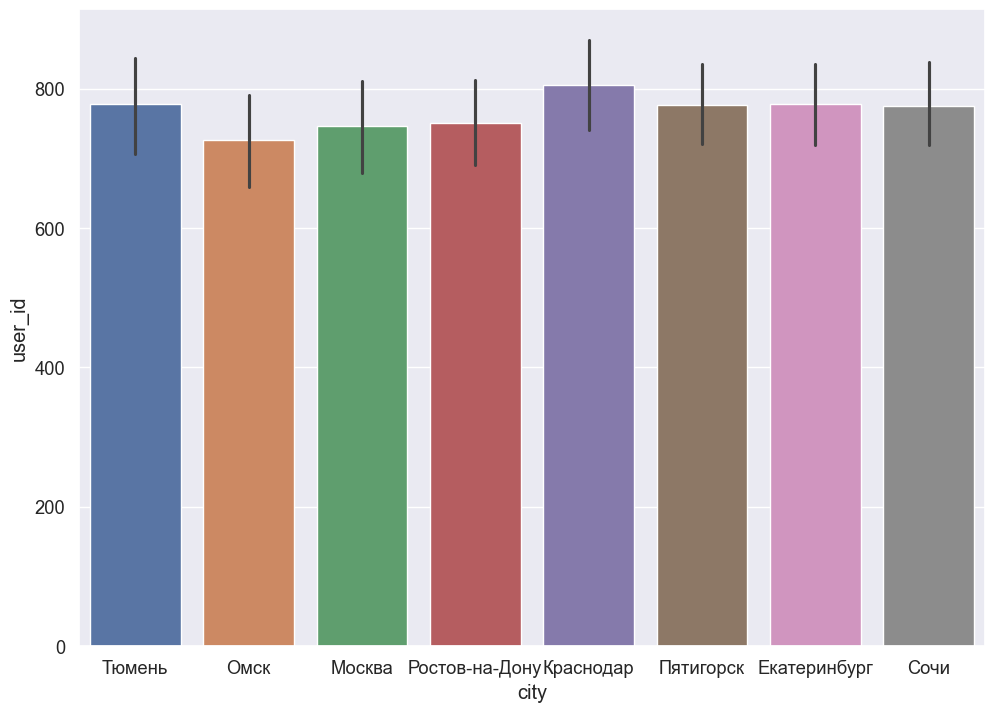

,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


In [40]:
sns.barplot(data=users, x='city', y='user_id', hue='city')
sns.set(font_scale=1.1)
plt.show()

users.pivot_table(index='city', 
                  values='user_id', 
                  aggfunc='count').sort_values('user_id', ascending=False)

наиболее востребованным сервис является в городах с более долгим тёплым сезоном. и, на удивление, в Екатеринбурге. можно предположить, что в данном городе сложились наиболее благоприятные условия для развития сервиса. однако в задачу данного исследование не входит исследование лояльности пользователей в зависимости отрегиона, пока ограничимся этим предположением.

### 3.2. SUBSCRIPTION TYPE

составим сводную таблицу и график, для того чтобы оценить соотношение пользователей без подписки к пользователям с подпиской.

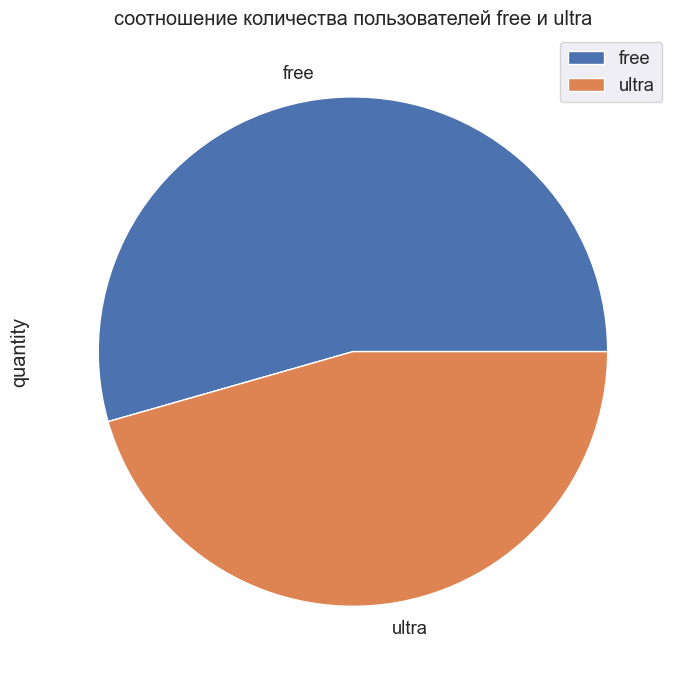

,quantity,%_of_total
subscription_type,,
free,835,54.4
ultra,699,45.6


In [15]:
subcribtion_pivot = (users.pivot_table(index='subscription_type', 
                  values='user_id', 
                  aggfunc='count').sort_values('user_id', ascending=False)
                     )

subcribtion_pivot.rename(columns = {'user_id': 'quantity'}, inplace=True)
subcribtion_pivot['%_of_total'] = (subcribtion_pivot['quantity'] / len(users) * 100).round(1)

subcribtion_pivot.plot(y='quantity', kind='pie')
plt.title('соотношение количества пользователей free и ultra')
plt.show()

subcribtion_pivot

пользователей с подпиской меньше, чем доля тех, кто катается просто так, что не критично с учётом того, что размер обеих подвыборок достаточен для проведения статистического анализа.

### 3.3. AGE

визуализируем распределение пользователей по возрасту с помощью гистограммы, обратившись к ранее написанной функции data_hist:

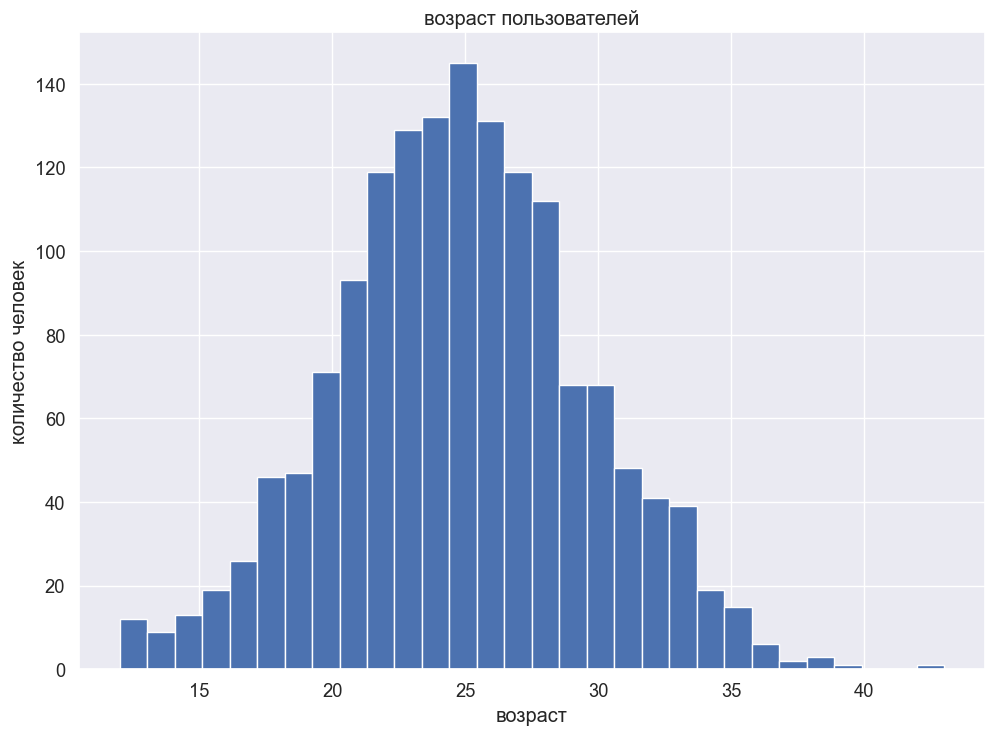

медиана: 25.0 
среднее: 24.9 
min: 12 
max: 43 
порог выбросов: 37.0 
нижний порог выбросов: 13.0


In [16]:
data_hist(users, 'age', 'возраст пользователей', 
          'возраст', 'количество человек', 
          30, (users['age'].min(), users['age'].max())
         )

медиана почти совпадает со средим &mdash; нормальное распределение пользователей по возрасту. основная доля катающихся приходится на возраст 22-28 лет.

### 3.4. DISTANCE
с помощью ранее написанной функции data_boxplot визуализируем распределение дистанций отдельно взятых заездов:

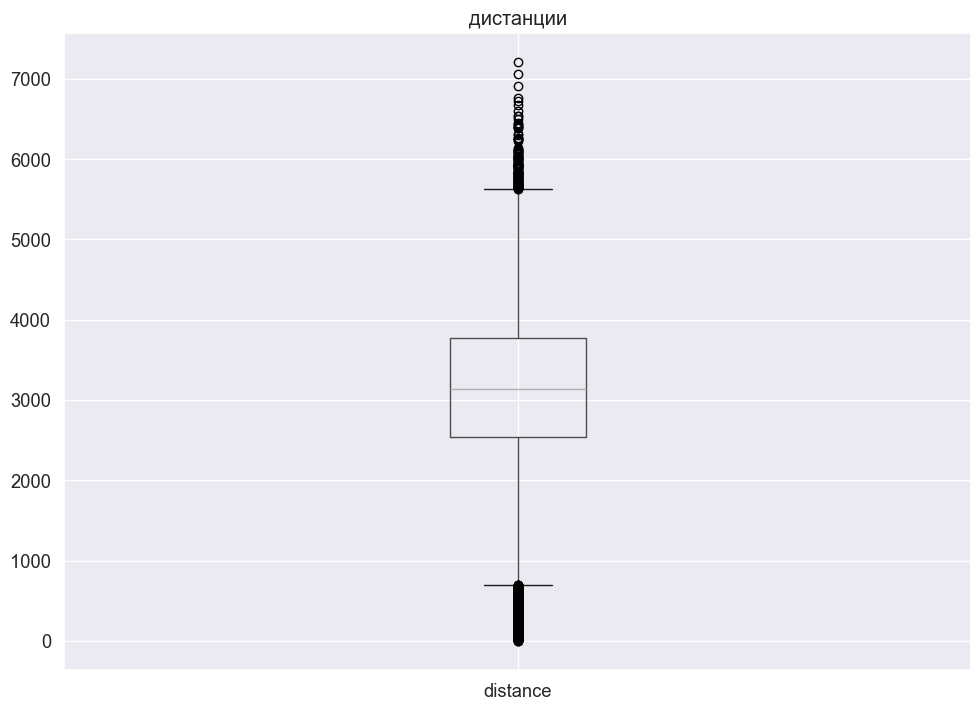

медиана: 3133.61 
среднее: 3070.7 
min: 0.86 
max: 7211.01 
верхний порог выбросов: 5625.7 
нижний порог выбросов: 693.7 
Q1: 2543.2 
Q3: 3776.2


In [17]:
data_boxplot(rides, 'distance', 'дистанции')

на графике видна плотная полоса выбросов: есть слишком короткие поездки, в которых что-то пошло не так (возможно, поломка самоката, либо по каким-то причинам пользователь решил отменить поездку), а также поездки на дистанции более 5.6 километров. разрыв между медианой и средним уже сильнее.

в рамках данного исследования мы не будем отсекать экстремальные значения. однако проверим, не связаны ли такие выбросы с месяцем поездки. возможно, летом люди предпочитают более долгие поездки, нежели осенью или зимой.

In [18]:
print(f"Количество экстремально дальних заездов: {len(rides.query('distance > 5625.7'))} \n"
      f"Доля от общего числа поездок: {len(rides.query('distance > 5625.7')) / rides.shape[0] * 100} \n" 
      f"Медианное расстояние по месяцам:"
     )
rides.query('distance > 5625.7').pivot_table(index='month', 
                                             values='distance', 
                                             aggfunc=['median', 'count'])

Количество экстремально дальних заездов: 126 
Доля от общего числа поездок: 0.6973655080805844 
Медианное расстояние по месяцам:


,median,count
,distance,distance
month,,
1,5801.695,14
2,6112.270,10
3,5868.240,8
4,5830.545,10
5,5916.955,10
6,5758.300,8
7,6115.130,10
8,5800.730,7


дальние заезды случаются не так часто и составляют менее 1% всех поездок, при этом дальность заеда совершенно не зависит от времени года: даже в южных регионах, где кататься на самокате зимой некомфортно, есть отчаянные пользователи.   теперь обратимся к суперкоротким поездкам:

In [19]:
print(f"Количество экстремально коротких заездов: {len(rides.query('distance < 693.7'))} \n"
      f"Доля от общего числа поездок: {len(rides.query('distance < 693.7')) / rides.shape[0] * 100} \n" 
      f"Медианное расстояние по месяцам:"
     )
rides.query('distance < 693.7').pivot_table(index='month', 
                                             values='distance', 
                                             aggfunc=['median', 'count'])

Количество экстремально коротких заездов: 910 
Доля от общего числа поездок: 5.036528669470887 
Медианное расстояние по месяцам:


,median,count
,distance,distance
month,,
1,402.270,68
2,420.425,78
3,416.750,89
4,488.410,75
5,387.580,66
6,474.400,63
7,402.040,67
8,384.580,90


сверхкоротких поездок значительно больше (уже 5% от общего числа поездок),  как и в случае с дальними дистанциями, тут ожидаемо не прослеживается зависимость от времени года. вероятно, короткие поездки связаны с техническими неполадками, которые мы не рассматриваем в нашем датасете.

### 3.5. DURATION
естественно предположить: раз есть выбросы в дистанции заездов, должны быть выбросы и в продолжительности. визуализируем распределение данных:

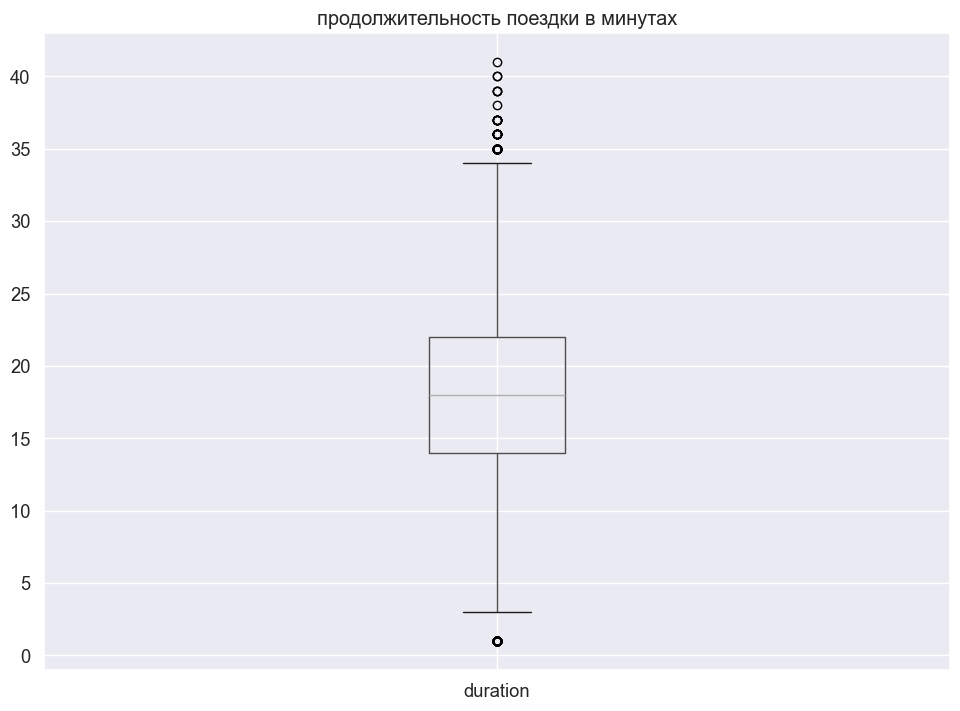

медиана: 18.0 
среднее: 18.3 
min: 1 
max: 41 
верхний порог выбросов: 34.0 
нижний порог выбросов: 2.0 
Q1: 14.0 
Q3: 22.0


In [20]:
data_boxplot(rides, 'duration', 'продолжительность поездки в минутах')

In [21]:
print(f"Количество экстремально долгих заездов: {len(rides.query('duration > 34'))} \n"
      f"Доля от общего числа поездок: {len(rides.query('duration > 34')) / rides.shape[0] * 100} \n \n"
      f"Количество экстремально быстрых заездов: {len(rides.query('duration < 2'))} \n"
      f"Доля от общего числа поездок: {len(rides.query('duration < 2')) / rides.shape[0] * 100} \n"
     )      

Количество экстремально долгих заездов: 75 
Доля от общего числа поездок: 0.4150985167146336 
 
Количество экстремально быстрых заездов: 95 
Доля от общего числа поездок: 0.5257914545052026 



на **126** экстремально дальних заездов приходится всего **75** экстремально долгих заездов. очевидно, среди наших пользователей есть любители стремительной езды на большие расстояния. надеюсь, они не забывают надевать шлем и соблюдают ПДД (:

ещё существеннее разница между короткими дистанциями и непродолжительными поездками: **910** против **95** соответственно. вероятно, не все пользователи, передумавшие ехать, смогли оперативно прервать поездку в приложении. в дальнейшем посмотрим, как много из них согласились пользоваться сервисом во второй раз и есть ли среди них те, кто решил оформить подписку.

#### Промежуточный итог
проведя исследовательский анализ данных, мы установили, что:
1. больше клиентов сервис имеет в регионах с более долгим тёплым периодом, а так же - в Екатеринбурге, где, вероятно, сложились благоприятные условия для развития сервиса.
2. пользователей, оформивших подписку, на 16% меньге, чем пользователей без подписки
3. средний (он же медианный) возраст нашего клиента &mdash; 25 лет. при этом больша часть наших пользователей &mdash; люди 22-28 лет
4. медианное значение дистанции поездки - 3.1 км, при этом наблюдаются суперкороткие поездки (менее полукилометра), а такде экстремальо длинные заезды: более 5.6 км.
5. в среднем длительность поездки составляет 18 минут, при этом основная доля длительности поездок приходится на 14-22 минуты.

## 4. Объединение данных и сравнение показателей
### 4.1. Создание датасетов, необходимых для статистического анализа данных

подготовим три датасета:
* `all_users` &mdash; здесь будет особрана полная инофрмация обо всех пользователях: поездки, тарифы и т.д.
* `ultra_users` &mdash; для пользователей, оформивших подписку
* `free_usrers` &mdash; для пользователей без подписки

In [22]:
all_users = rides.merge(users, on='user_id', how='outer')
all_users = all_users.merge(subscriptions, on='subscription_type', how='outer')
all_users

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.92,26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.59,16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,7,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.78,19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.69,27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.10,20,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.42,22,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.19,19,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.31,17,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


проверим результат объединения таблиц: количество строк в исходной таблице `rides` должно совпадать с количеством строк в получившейся табдице `all_users`. так же проверим, не появились ли в новом датасет пропуски.

In [23]:
print(f"Количество строк в исходном датасете rides: {len(rides)} \n"
     f"Количество строк в конечном датасете all_users: {len(all_users)} \n"
     f"Количество пропущенных значений в датасете all users: \n{all_users.isna().sum()}")

Количество строк в исходном датасете rides: 18068 
Количество строк в конечном датасете all_users: 18068 
Количество пропущенных значений в датасете all users: 
user_id              0
distance             0
duration             0
date                 0
month                0
name                 0
age                  0
city                 0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


все строки на месте, пропущенные значения не появились &mdash; объединение таблиц прошло успешно.

отсечём от общего датасета поездки пользователей, оформивших подписку:

In [24]:
ultra_users = all_users.query("subscription_type == 'ultra'")
ultra_users

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.92,26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.59,16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,7,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.78,19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.69,27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,3973.05,25,2021-08-29,8,Оксана,22,Москва,ultra,6,0,199
6496,699,3288.70,16,2021-09-12,9,Оксана,22,Москва,ultra,6,0,199
6497,699,3076.16,15,2021-09-26,9,Оксана,22,Москва,ultra,6,0,199
6498,699,4707.85,16,2021-10-17,10,Оксана,22,Москва,ultra,6,0,199


то же самое сделаем для пользователей, катающихся без подписки:

In [25]:
free_users = all_users.query("subscription_type == 'free'")
free_users

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.69,15,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.93,17,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.43,21,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.91,10,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.38,18,2021-02-14,2,Айдар,22,Омск,free,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.10,20,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.42,22,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.19,19,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.31,17,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


мы получили три таблицы, одна из которых содержит информацию обо всех **18068** заездах, вторая &mdash; данные о **6500** заездах пользователей с подпиской и третья &mdash; данные о **11568** заездах без подписки. ранее мы посчитали, что людей без подписки немногим больше: 835 против 699, однако не будем спешить с выводами, пока не изучим длительность поездок и прибыльность каждой группы.

### 4.2. Сравнение распределений данных

сперва сравним достижения в дальности заездов пользователей `ultra` и `free`:

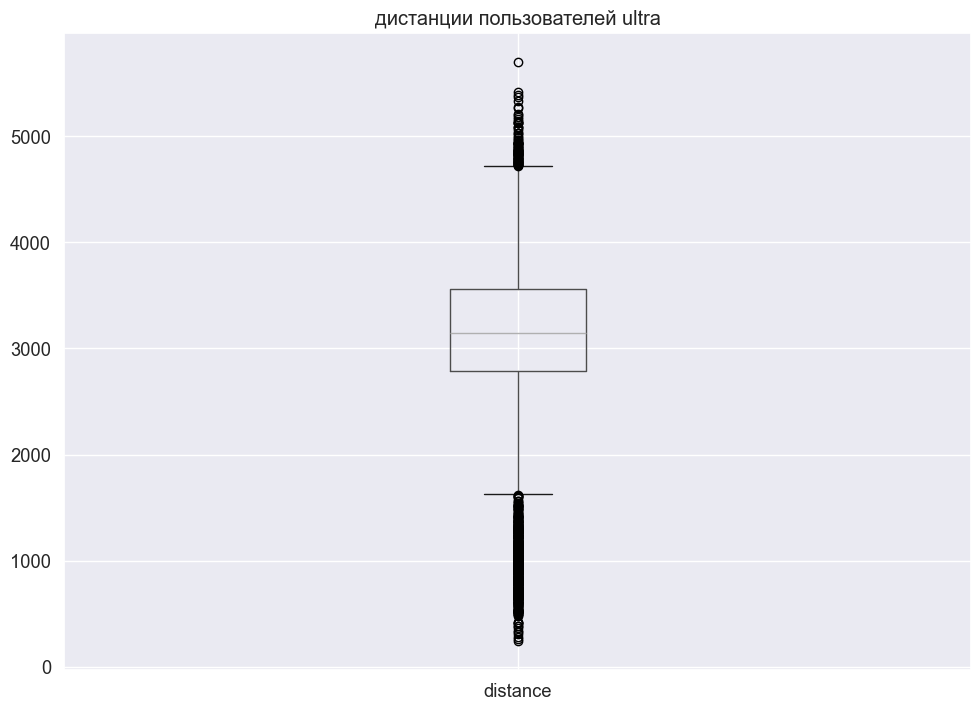

медиана: 3148.6400000000003 
среднее: 3115.4 
min: 244.21 
max: 5699.77 
верхний порог выбросов: 4723.4 
нижний порог выбросов: 1622.6 
Q1: 2785.4 
Q3: 3560.6


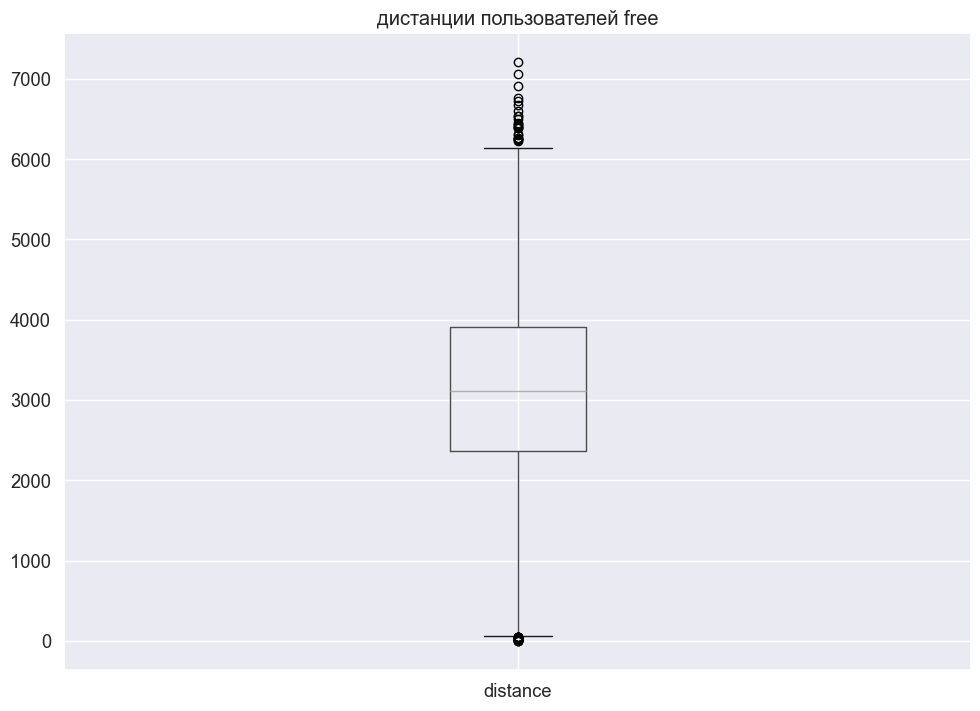

медиана: 3114.6499999999996 
среднее: 3045.5 
min: 0.86 
max: 7211.01 
верхний порог выбросов: 6214.35 
нижний порог выбросов: 57.95 
Q1: 2366.6 
Q3: 3905.7


In [26]:
data_boxplot(ultra_users, 'distance', 'дистанции пользователей ultra')

data_boxplot(free_users, 'distance', 'дистанции пользователей free')

средняя дистанция заезда примерно одинаковая для пользователей обеих групп, однако судя по первому квартилю, юзеры, решившие стать постоянными клиентами, не отказываются от поездки, едва встав на самокат (1623 метра против 58 метров). наименьшая дистанция, которая в группе с подпиской является выбросом (244 метра), почти в раза больше нижнего порога выбослв во второй группе. люди с подпиской катаются наверняка, зато люди без подписки, если не отказались от поездки, преодолевают б**о**льшие дистанции. для наглядности сравнения отобразим оба графика на одном поле:

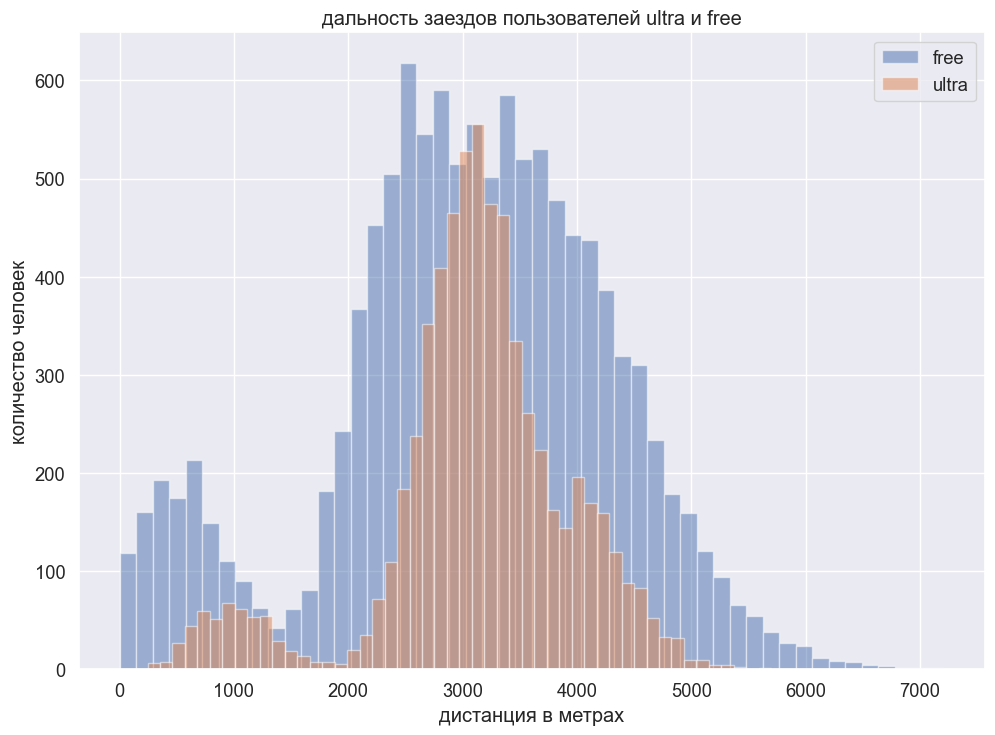

In [27]:
free_users['distance'].hist(alpha=0.5, label='free', bins = 50)
ultra_users['distance'].hist(alpha=0.5, label='ultra', bins = 50)

plt.title('дальность заездов пользователей ultra и free')
plt.xlabel('дистанция в метрах')
plt.ylabel('количество человек')
plt.legend()
plt.show()

а теперь построим аналогичные графики для продолжительности поездок в обеих категориях:

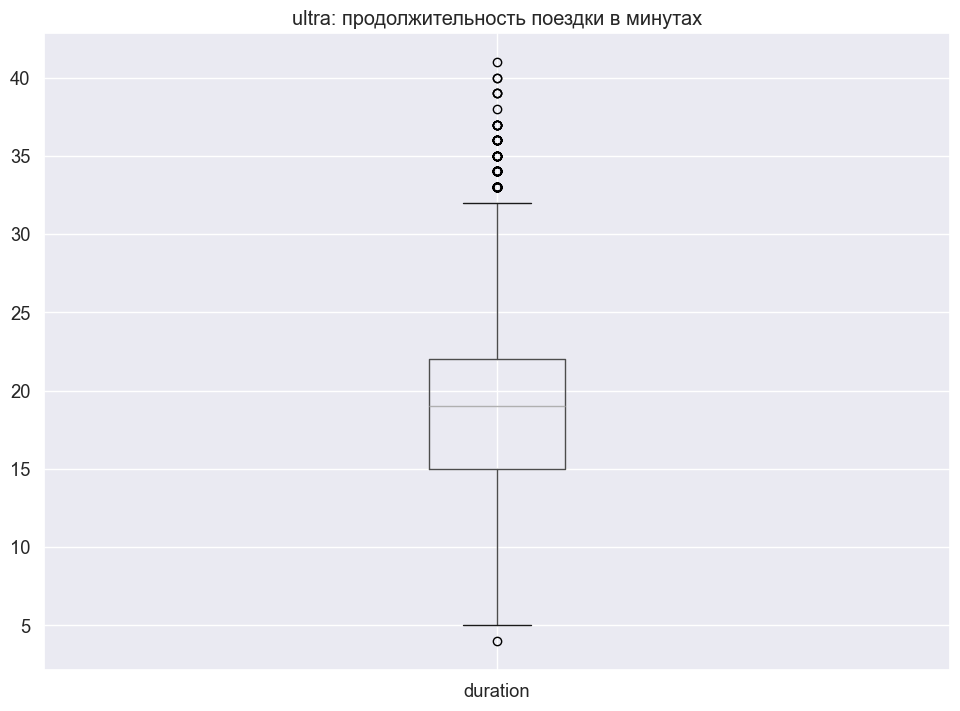

медиана: 19.0 
среднее: 19.0 
min: 4 
max: 41 
верхний порог выбросов: 32.5 
нижний порог выбросов: 4.5 
Q1: 15.0 
Q3: 22.0


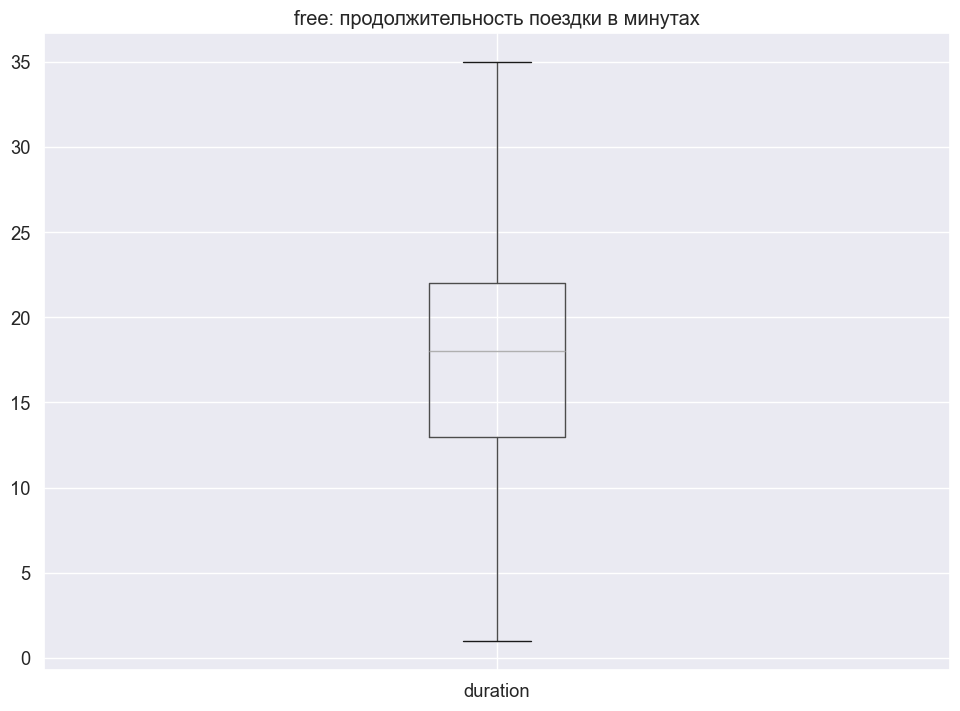

медиана: 18.0 
среднее: 17.9 
min: 1 
max: 35 
верхний порог выбросов: 35.5 
нижний порог выбросов: -0.5 
Q1: 13.0 
Q3: 22.0


In [28]:
data_boxplot(ultra_users, 'duration', 'ultra: продолжительность поездки в минутах')

data_boxplot(free_users, 'duration', 'free: продолжительность поездки в минутах')

в среднем поездка подписочных пользователей длится на минуту дольше, что ожидаемо, так как в среднем оформившие подписку проезжают б**о**льшие расстояния. также ранее мы подметили, что в датасете есть информация о 95 экстремально коротких заездов, длившихся не более 2 минут: по графикам выше видно, что такие заезды совершают пользователи, не офрмившие подписку.

для наглядности визуализируем оба распределения на одном поле:

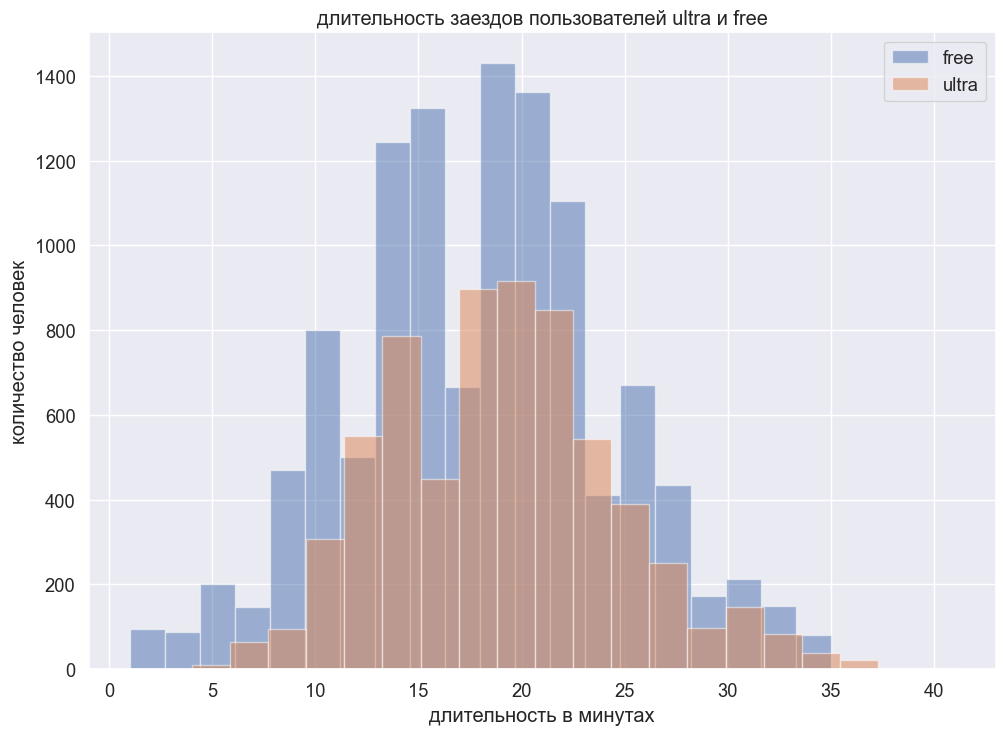

In [29]:
free_users['duration'].hist(alpha=0.5, label='free', bins = 20)
ultra_users['duration'].hist(alpha=0.5, label='ultra', bins = 20)

plt.title('длительность заездов пользователей ultra и free')
plt.xlabel('длительность в минутах')
plt.ylabel('количество человек')
plt.legend()
plt.show()

#### Промежуточный итог
для статистического анализа данных мы подготовили три датасета с полной информацией о пользователях и совершённых ими поездках: один общий датасет и два &mdash; для групп клиентов с подпиской и без. сравнив распределение данных в разных группах пользователей, мы установили, что наличие подписки обеспечивает большую длину и продолжительность заездов.

## 5. Подсчёт выручки

создадим сводную таблицу, в которой агрегируем данные о поездках на основе датафрейма `all_users`: найдём общее расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц, а также посчитаем помесячную выручку для каждого пользователя.  

In [30]:
all_users_pivot = (all_users.pivot_table(index=['user_id', 'month'], 
                                         values=['distance', 'duration', 'minute_price',
                                                 'start_ride_price', 'subscription_fee'],
                                         aggfunc={'distance':{'count', 'sum'},
                                                  'duration':'sum', 'minute_price': 'mean',
                                                  'start_ride_price':'mean',
                                                  'subscription_fee':'mean'}
                                        )
                   .reset_index()
                   )
all_users_pivot.columns = ['user_id', 'month', 'quantity', 
                           'distance', 'duration', 'minute_price', 
                           'start_ride_price', 'subscription_fee']

print(f"Количество пропусков в данных: \n{all_users_pivot.isna().sum()}")
all_users_pivot

Количество пропусков в данных: 
user_id             0
month               0
quantity            0
distance            0
duration            0
minute_price        0
start_ride_price    0
subscription_fee    0
dtype: int64


,user_id,month,quantity,distance,duration,minute_price,start_ride_price,subscription_fee
0,1,1,2,7027.51,42,6.0,0.0,199.0
1,1,4,1,754.16,7,6.0,0.0,199.0
2,1,8,2,6723.47,46,6.0,0.0,199.0
3,1,10,2,5809.91,32,6.0,0.0,199.0
4,1,11,3,7003.50,56,6.0,0.0,199.0
...,...,...,...,...,...,...,...,...
11326,1534,6,2,3409.47,26,8.0,50.0,0.0
11327,1534,8,2,7622.45,48,8.0,50.0,0.0
11328,1534,9,1,4928.17,23,8.0,50.0,0.0
11329,1534,11,4,13350.02,78,8.0,50.0,0.0


пропусков нет &mdash; можно рассычитывать помесячную выручку. создадим новый столбец `revenue`, в котором рассчитаем выручку по формуле: `соимость старта * количество поездок + стоимость минуты * длительность + стоимость подписки`.

In [31]:
all_users_pivot['revenue'] = (all_users_pivot['start_ride_price']  * all_users_pivot['quantity']
                              + all_users_pivot['duration'] *  all_users_pivot['minute_price']
                              + all_users_pivot['subscription_fee']
                             )
all_users_pivot

,user_id,month,quantity,distance,duration,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,2,7027.51,42,6.0,0.0,199.0,451.0
1,1,4,1,754.16,7,6.0,0.0,199.0,241.0
2,1,8,2,6723.47,46,6.0,0.0,199.0,475.0
3,1,10,2,5809.91,32,6.0,0.0,199.0,391.0
4,1,11,3,7003.50,56,6.0,0.0,199.0,535.0
...,...,...,...,...,...,...,...,...,...
11326,1534,6,2,3409.47,26,8.0,50.0,0.0,308.0
11327,1534,8,2,7622.45,48,8.0,50.0,0.0,484.0
11328,1534,9,1,4928.17,23,8.0,50.0,0.0,234.0
11329,1534,11,4,13350.02,78,8.0,50.0,0.0,824.0


посмотрим основные статистики и распределение для каждой группы пользователей в отдельности:

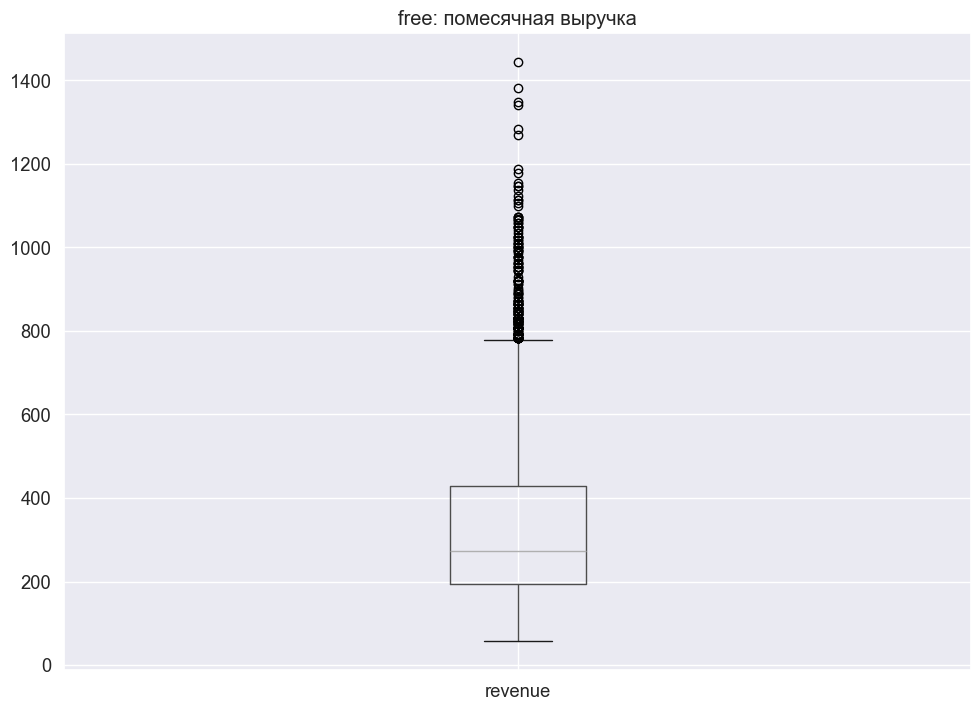

медиана: 274.0 
среднее: 328.6 
min: 58.0 
max: 1444.0 
верхний порог выбросов: 779.0 
нижний порог выбросов: -157.0 
Q1: 194.0 
Q3: 428.0


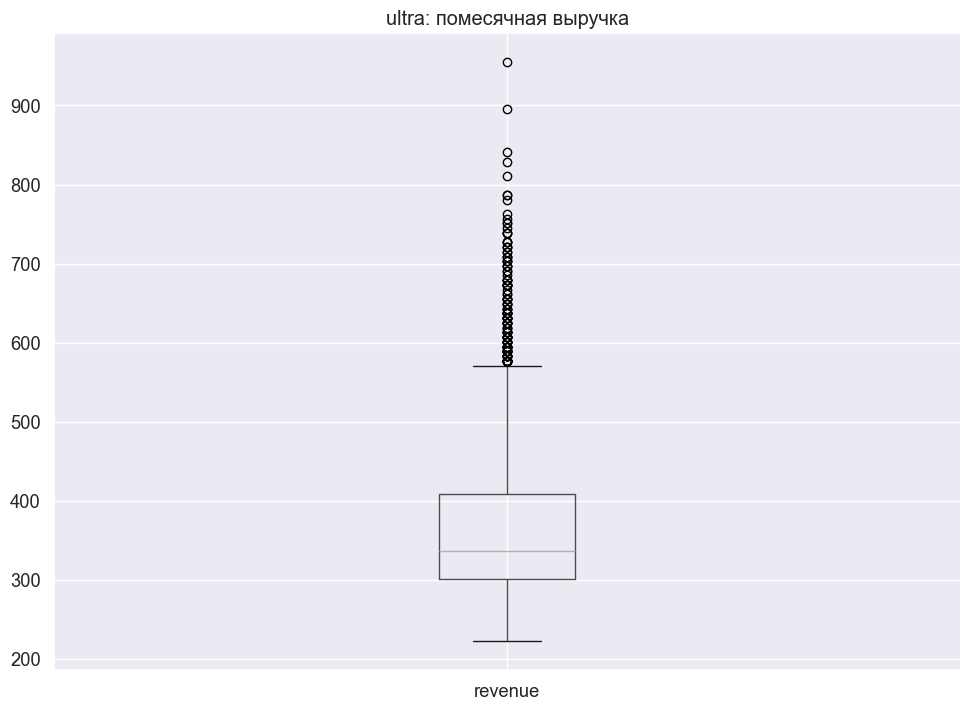

медиана: 337.0 
среднее: 362.8 
min: 223.0 
max: 955.0 
верхний порог выбросов: 571.0 
нижний порог выбросов: 139.0 
Q1: 301.0 
Q3: 409.0


In [32]:
data_boxplot(all_users_pivot.query('subscription_fee == 0'), 
             'revenue', 
             'free: помесячная выручка')

data_boxplot(all_users_pivot.query('subscription_fee != 0'), 
             'revenue', 
             'ultra: помесячная выручка')

медианное значение помесячной выручки от пользователей с подпиской на 79 рублей больше, также есть отличия в большую сторону для первого и третьего квартиля. пользователи. очевидно, что пользователи от пользователей с подпиской можно получать стабильно большую прибыль, чем от простых пользователей. 

для наглядности визуализируем оба распределения на одном поле:

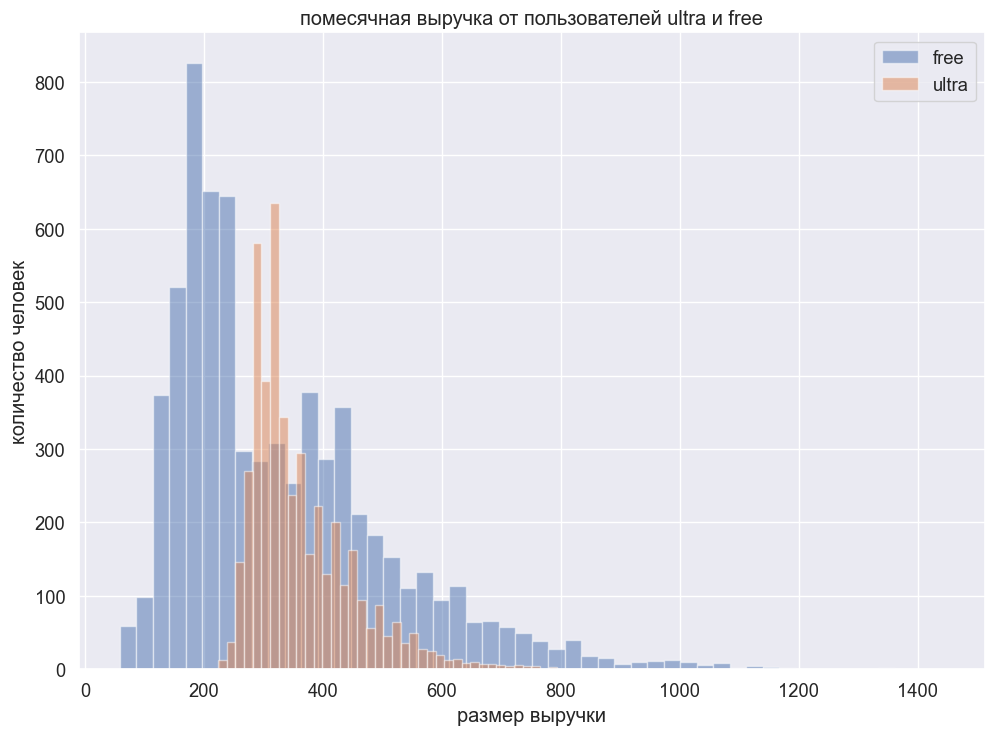

In [33]:
all_users_pivot.query('subscription_fee == 0')['revenue'].hist(alpha=0.5, label='free', bins = 50)
all_users_pivot.query('subscription_fee != 0')['revenue'].hist(alpha=0.5, label='ultra', bins = 50)

plt.title('помесячная выручка от пользователей ultra и free')
plt.xlabel('размер выручки')
plt.ylabel('количество человек')
plt.legend()
plt.show()

#### Промежуточный итог
мы провели все необходимые манипуляции и с данными и подготовили их для проверки гипотез.
## 6. Проверка гипотез

### 6.1 Гипотеза 1. Продолжительность.

$H_0$: средние продолжительности заездов в обеих группах одинановы  
$H_1$: средняя продолжительность заездов у пользователей `ultra` выше

для сравнения воспользуемся создаными ранее датасетами free_users и ultra_users.  
ранее мы выяслили, что поездок, совершённых подписочными пользователями, почти в два раза меньше, это существенная разница в объёме выборок, поэтому при проведении t-теста установим `equal_var = False`. данные выборки являются независимыми &mdash; для анализа будем использовать соответствующий тест.

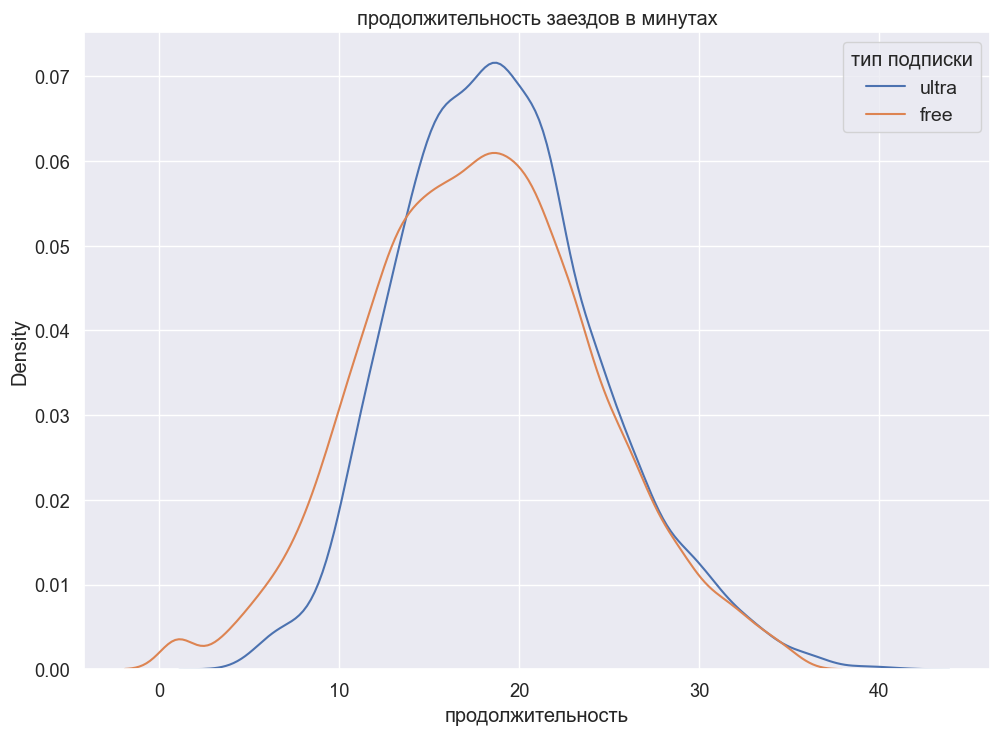

p-значение: 1.1814679253701353e-36
Отвергаем нулевую гипотезу


In [34]:
sns.kdeplot(ultra_users['duration'], label="ultra")
sns.kdeplot(free_users['duration'], label="free")

plt.title('продолжительность заездов в минутах')
plt.xlabel('продолжительность')
plt.legend(prop={'size': 14}, title = 'тип подписки', loc="upper right")

plt.show()

results = st.ttest_ind(ultra_users['duration'], 
                       free_users['duration'], 
                       equal_var = False, 
                       alternative='greater')
alpha = 0.05

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


действительно, можно отвергнуть гипотезу о равенстве средних в пользу гипотезы о том, что пользователи по подписке катаются дольше.

### 6.2. Гипотеза 2 Дистанция
3130 метров &mdash; оптимальное расстояние одной поездки с учётом износа самоката. на ранних этапах исследования мы обратили внимание на то, что для пользователей `ultra` характерны менее протяжённые заезды. а теперь проверим гипотезу коллег.

$H_0$: средняя дистанция поездок `ultra` равна 3130 метров  
$H_1$: средняя дистанция поездок `ultra` превышает оптимальные 3130 метров.

для проверки гипотезы используем t-test для одной выборки с указанием параметра `alternative='less'`

In [35]:
perfect_distance = 3130

alpha = 0.05

results = st.ttest_1samp(
    ultra_users['distance'], 
    perfect_distance, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195362605842414
Не получилось отвергнуть нулевую гипотезу


нам не удалось подтвердить гипотезу о том, что поездки пользователей, оформивших подписку, в среднем превышают дистанцию 3130 метров. следовательно, можно полагать, что поездки пользователей `ultra` не приводят к повышенному износу самокатов.

### 6.3. Гипотеза 3 Выручка
какая из групп пользователей приносит больше выручки сервису?  
$H_0$: среднее помесячных выручек пользователей `ultra` равно агалогичному показателю `free`  
$H_1$: среднее помесячных выручек пользователей `ultra` больше агалогичного показателя `free`

для проверки гипотез воспользуемся t-тестом для двух независимых выборок. ранее в исследовании мы установили, что поездок, совершённых пользователями по подписке, почти в два раза меньше, поэтому при расчётах выставим `equal_var = False`

In [36]:
# сформируем срез данных по вхождению значения user_id в ранее созданные списки:
free_users_pivot = all_users_pivot.query('subscription_fee == 0')
ultra_users_pivot = all_users_pivot.query('subscription_fee != 0')

# проведём t-test:
results = st.ttest_ind(ultra_users_pivot['revenue'], 
                       free_users_pivot['revenue'],
                       equal_var = False,
                       alternative='greater')
alpha = 0.05

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 8.874140893976874e-40
Отвергаем нулевую гипотезу


можем отвергнуть нулевую гипотезу в пользу предположения о том, что средняя помесячая выручка пользователей с подпиской выше, чем пользователей без подписки. дело за малым: мотивировать пользователей оформлять подписку (:

### 6.4. Обращения в техподдержку.
для того чтобы изменить динамику обращений в техподдержку после обновления серверов, нам потребуется провести анализ двух выборок: список обращений, поступивших до обновлений, и список обращений после. инструментом анализа будет t-test для зависимых выборок, которые необходимо будет предварительно сделать равными по количеству элементов. **для проверки следует брать одностороннюю гипотезу, так как мв ожидаем значимое снижение количества обращений**


## 7. Рассчёт маркетинговых активностей
### 7.1. Промокоды на подписку
отделу маркетинга необходимо узнать, какое количество промокодов на месяц бесплатной подписки нужно отправить пользователям, чтобы вероятность не выполнить план по продлению подписки не превысила 5%. ожидается, что не менее 100 человек продлят подписку. опыт аналогичных кампаний в прошлом показал, что 10% пользователей продлевают подписку после пробного периода.

вероятность не выполнить план не превышает 0.05 
при количестве промокодов равном 1161


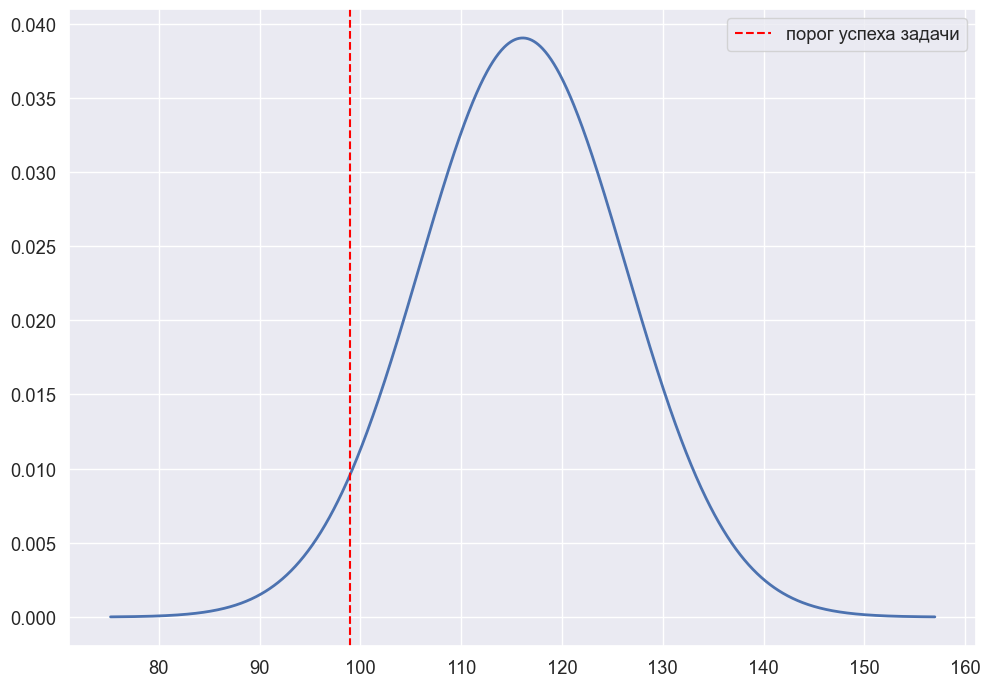

In [37]:
n = 1000
k = 99 # вычитаем из 100 единицу, т.к. нас интересует вероятнось не выполнить план.
p = 0.1

p_2 = 0.05

while p_2 < binom.cdf(k, n, p):
    n += 1

print(f"вероятность не выполнить план не превышает {binom.cdf(k, n, p).round(2)} \n"
      f"при количестве промокодов равном {n}")

# т.к. распределение является биноминальным (подписку либо продолжат, либо нет),
# вычислим mu и sigma по соответствующим формулам:
mu = n * p
sigma = (n * p * (1 - p))**0.5

# зададим область построения графика слева и справа:      
left = mu - 4 * sigma
right = mu + 4 * sigma
x = np.linspace(left, right, 1161) # сгенерируем значения в заданной области.

theplot = plt.subplot()
theplot.plot(x, st.norm.pdf(x, mu, sigma), 'b-', lw=2)
plt.axvline (x=k, color='red', linestyle='--', label='порог успеха задачи')
plt.legend() 
plt.show()

### 7.2. Рассылка push-уведомлений

отдел маркетинга планирует разослать 1000000 уведомлений. мы знаем, что их открывают около 40% клиентов. построим примерный график распределения и оценим вероятность того, что уведомление откроют не более 399500 пользователей.

так как поведение пользователей в данной ситуации является биноминальным распределением (пуш либо откроют, либо нет), а наблюдений у нас довольно много, посмользуемся нормальной аппроксимацией биномиального распределения и методом `.cdf()` 

Вероятность открытия сообщений: 0.15371708296369768


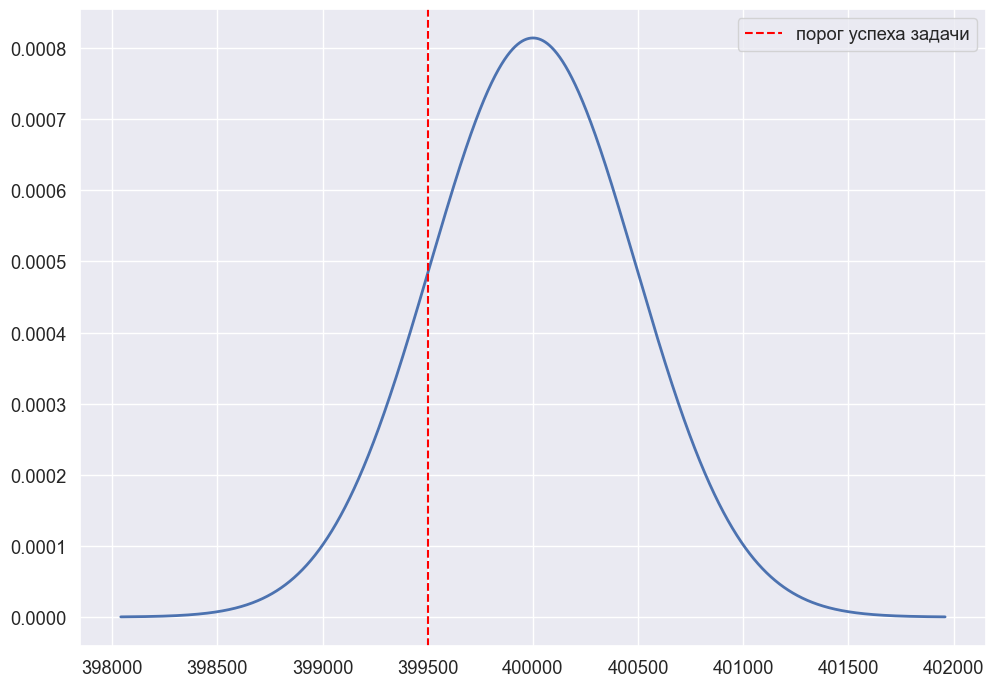

In [38]:
n = 1000000
p = 0.4
k = 399500

mu = n * p
sigma = (n * p * (1 - p))**0.5

distr = st.norm(mu, sigma)

result = distr.cdf(k)
print('Вероятность открытия сообщений:', result)

left = mu - 4 * sigma
right = mu + 4 * sigma

x = np.linspace(left, right, 1000000)
theplot = plt.subplot()
theplot.plot(x, st.norm.pdf(x, mu, sigma), 'b-', lw=2)
plt.axvline (x=k, color='red', linestyle='--', label='порог успеха задачи')
plt.legend()

plt.show()

## 8. Выводы
нам удалось выяснить, что средний возраст нашего клиента &mdash; 25 лет, а большая часть наших пользователей &mdash; люди  22-28 лет, у которых средняя дистанция заезда чуть более 3 километров при средней продолжительности 18 минут, а основная доля поездок (по длительности) приходится на 14-22 минуты. при этом наличие подписки обеспечивает большую длину и продолдительность заездов. 

также мы:
1. проверили три гипотезы от наших коллег:
* средняя продолжительность заездов у пользователей ultra выше - это действительно так.
* средняя дистанция поездок ultra не превышает оптимальных 3130 метров - поездки пользователей с подпиской не приводят к более сильному износу самокатов.
* среднее помесячных выручек пользователей ultra больше агалогичного показателя free - статистически значимое подтверждение гипотезы получено.
2. определили пороговые значения для маркетинговых кампаний:
* нужно выдать 1161 промокод на пробную подписку, чтобы вероятность не выполнить план по подписке не превысила 5%
* вероятность того, что из 1 млн. отправленных пушей будут открыты не более 399,5 тысяч, составляет 15.3%

в целом можно говорить о том, что подписка  &mdash; выгодное решение для сервиса, так как постоянные клиенты `ultra` обеспечивают стабильно больший ежемесячный доход: медианное значение помесячной выручки **337 рублей** против аналогичного показателя **258 рублей** у обычных пользователей. максимальная помесячная (без учёта выбросов) выручка от пользователей с подпиской также больше: **634** против **571** рубля.

стимулирование перевода пользователей из категории `free` в категорию `ultra` таже будет способствовать меньшему износу самокатов: мы выяснили, что наибольшая дистанция заездов (без учёта выбросов) у пользователей с подпиской почти на полтора километра меньше, чем у простых пользователей (4.7 км против 6.2 км). также есть основания полагать, что в среднем заезды подписчиков не превышают оптимальной дистанции в 3130 метров.

при этом у пользователей `ultra` почти нет суперкоротких заездов, что может говорить о низком показателе отказа от поездки, что важно для бизнеса: самокатом, от которого через две минуты отказался пользователь без подписки, мог бы воспользоваться наш постоянный клиент.